<a href="https://colab.research.google.com/github/cyrusfrog/Medical-Waste-Classification/blob/main/medical_waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
data_dir='./drive/MyDrive/z'

In [3]:
import os
os.listdir(data_dir)

['hazardous', 'general', 'infectious']

In [4]:
from torchvision.datasets import ImageFolder

In [5]:
dataset=ImageFolder(data_dir)

In [6]:
len(dataset)

1754

In [7]:
dataset.classes

['general', 'hazardous', 'infectious']

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import torchvision.transforms as tt
dataset=ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                          tt.RandomCrop(64),
                                          tt.ToTensor()]))

In [10]:
val_pct=0.1
val_size=int(val_pct * len(dataset))
train_size = len(dataset)-val_size
train_size, val_size

(1579, 175)

In [11]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(1579, 175)

In [12]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

utility functions

In [14]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [15]:
torch.cuda.is_available()

True

In [16]:
device=get_default_device()

In [17]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [21]:
model=to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [22]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [23]:
torch.cuda.empty_cache()
for batch in train_dl:
  images,labels=batch
  print('images shape', images.shape)
  print('images device', images.device)
  preds=model(images)
  print('preds shape', preds.shape)
  break


images shape torch.Size([128, 3, 64, 64])
images device cuda:0
preds shape torch.Size([128, 3])


##TRAINING

In [24]:
history=[evaluate(model,valid_dl)]
history

[{'val_loss': 1.1143121719360352, 'val_acc': 0.2572306990623474}]

In [25]:
#history+= fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

In [26]:
#history+= fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

In [27]:
#history+= fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

In [28]:
#history+= fit(5, 0.0001, model, train_dl, valid_dl)

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [30]:
#plot_accuracies(history)

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [32]:
#plot_losses(history)

##TEST

In [33]:
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

In [34]:
def show_image_prediction(img, label):
  plt.imshow(img.permute(1,2,0))
  pred=predict_image(img, model, dataset.classes)
  print('Target: ', dataset.classes[label])
  print('Prediction: ', pred)

In [35]:
#show_image_prediction(*valid_ds[0])

## transfer learning

In [36]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [37]:
model= to_device(ResNet34(len(dataset.classes), pretrained=True), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


In [38]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset=ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                          tt.RandomCrop(img_size),
                                          tt.ToTensor(),
                                          tt.Normalize(*imagenet_stats)]))

In [39]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 64

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [40]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [41]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
history=[evaluate(model, valid_dl)]
history

[{'val_loss': 1.2232699394226074, 'val_acc': 0.33034130930900574}]

In [43]:
history+=fit_one_cycle(5, 0.0001, model, train_dl, valid_dl,weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7808, val_loss: 0.1728, val_acc: 0.9423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1025, val_loss: 0.0648, val_acc: 0.9929


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0358, val_loss: 0.0778, val_acc: 0.9650


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0182, val_loss: 0.0828, val_acc: 0.9650


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0140, val_loss: 0.0446, val_acc: 1.0000


In [44]:
import joblib

In [45]:
model_save = {'model' : model, 'train_ds' : train_ds, 'valid_ds' : valid_ds, 'train_dl' : train_dl, 'valid_dl' : valid_dl, 'history' : history}

In [46]:
joblib.dump(model_save, 'model_save.joblib')

['model_save.joblib']

In [47]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [48]:
import numpy as np

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

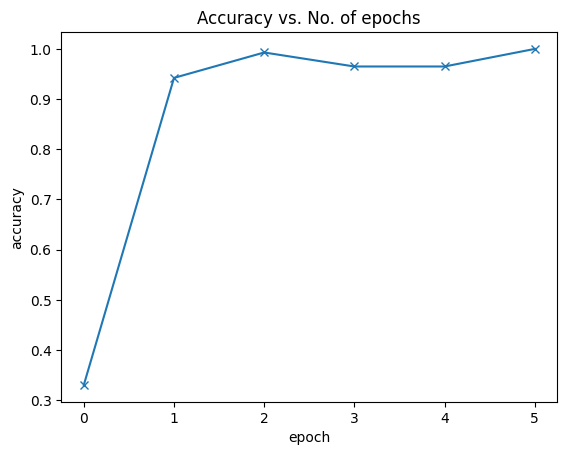

In [49]:
plot_accuracies(history)

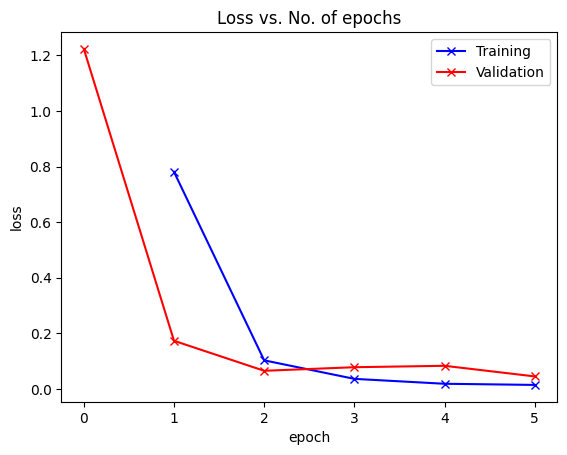

In [50]:
plot_losses(history)

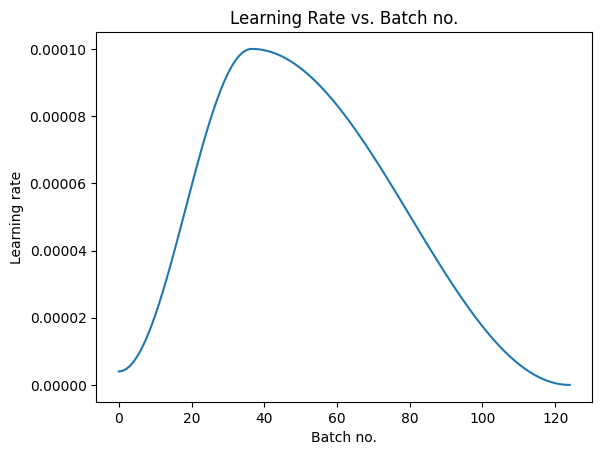

In [51]:
plot_lrs(history)

Target:  general
Prediction:  general


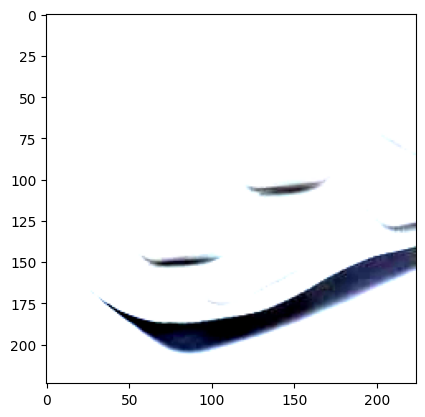

In [52]:
show_image_prediction(*valid_ds[16])

Target:  infectious
Prediction:  infectious


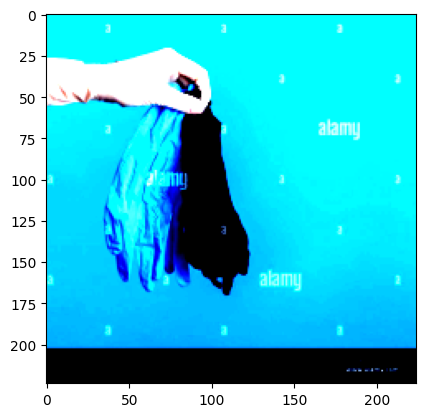

In [53]:
show_image_prediction(*valid_ds[150])

Target:  hazardous
Prediction:  hazardous


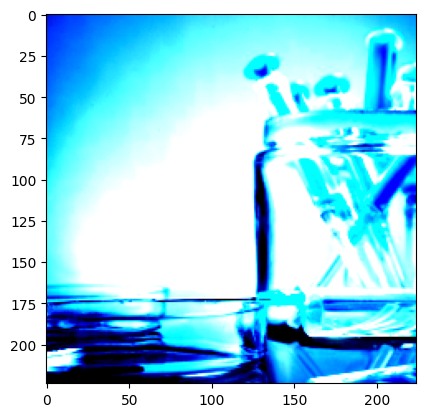

In [54]:
show_image_prediction(*valid_ds[56])

Target:  infectious
Prediction:  infectious


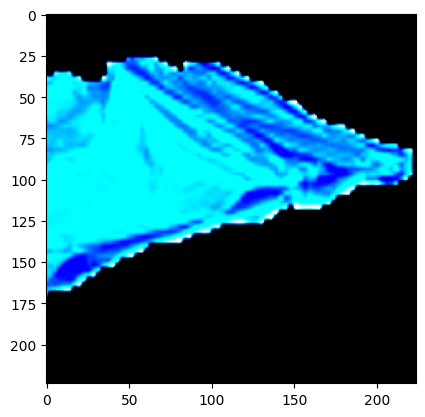

In [55]:
show_image_prediction(*valid_ds[64])

Target:  infectious
Prediction:  hazardous


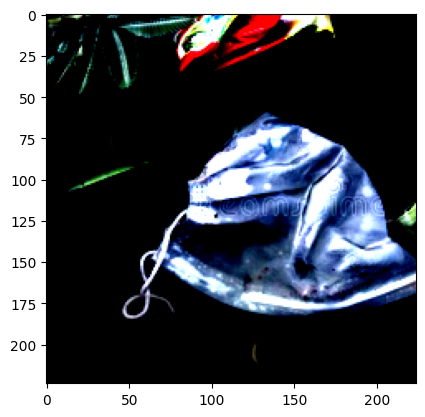

In [56]:
show_image_prediction(*valid_ds[90])

In [57]:
torch.save(model.state_dict(), 'medical waste.pth')

In [58]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [59]:

from PIL import Image
from torchvision import models, transforms
import torch
import streamlit as st
st.title("Simple Image Classification Application")
st.write("")
file_up = st.file_uploader("Upload an image", type = "jpg")


def predict(image):
    """Return top 5 predictions ranked by highest probability.

    Parameters
    ----------
    :param image: uploaded image
    :type image: jpg
    :rtype: list
    :return: top 5 predictions ranked by highest probability
    """
    # create a ResNet model
    resnet = models.resnet101(pretrained = True)

    # transform the input image through resizing, normalization
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
            )])

    # load the image, pre-process it, and make predictions
    img = Image.open(image)
    batch_t = torch.unsqueeze(transform(img), 0)
    resnet.eval()
    out = resnet(batch_t)

    with open('imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    # return the top 5 predictions ranked by highest probabilities
    prob = torch.nn.functional.softmax(out, dim = 1)[0] * 100
    _, indices = torch.sort(out, descending = True)
    return [(classes[idx], prob[idx].item()) for idx in indices[0][:5]]


if file_up is not None:
    # display image that user uploaded
    image = Image.open(file_up)
    st.image(image, caption = 'Uploaded Image.', use_column_width = True)
    st.write("")
    st.write("Just a second ...")
    labels = predict(file_up)

    # print out the top 5 prediction labels with scores
    for i in labels:
        st.write("Prediction (index, name)", i[0], ",   Score: ", i[1])

2023-10-06 21:29:22.664 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


##the end